# Predicting Pest Counts - NH farms 

# Ram Gautam 

In [509]:
import pandas as pd 
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [510]:
import  seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# 1. Multiple Linear Regression 

In [511]:
def Multiple_Linear_Regression(df_LinearRegression):
    #print (df_CEW_final.head())
    #print("Calling Multiple Linear Regression Modle")
    #print(sns.distplot(df_CEW_final['trap_count']))
    X_LR = df_LinearRegression[['tempf', 'dwpf', 'drct', 'feel']]
    y_LR = df_LinearRegression['trap_count']
    
    #splitting data into training and testing data
    X_train_lm, X_test_lm, y_train_lm,y_test_lm = train_test_split(X_LR,y_LR, test_size = 0.2, random_state = 101)
    #traing the data into the model
    regressionModel = LinearRegression()
    regressionModel.fit(X_train_lm, y_train_lm)
    
    #get the intercept
    print("Intercept: " , regressionModel.intercept_)
    
    #get the coeffecients
    print("Coeffecients " , regressionModel.coef_)
    
    #do the predictions - we need to pass the featuress that the model never seen before
    predictions = regressionModel.predict(X_test_lm)
    predictions_ret = regressionModel.predict(X_LR)
    print(predictions.shape)
    
    #print(y_test_lm)
    
    #cheking with the sctter plot 
    plt.scatter(y_test_lm , predictions)
    
    print("----------- Linear Regression Evaluations------------")
    print("Mean Absolute Error (MAE): ", metrics.mean_absolute_error(y_test_lm , predictions))
    print("Mean Squared Eror (MSE): ", metrics.mean_squared_error(y_test_lm , predictions))
    print("Root Mean Squared Eror (RMSE): ", np.sqrt(metrics.mean_squared_error(y_test_lm , predictions)))
    
    #sns.distplot((y_test_lm - predictions))
    df_LinearRegression['regression_count'] = predictions_ret
    
    return df_LinearRegression


# 2. Poisson Regression

In [512]:
def Poisson_Regression(df_Poisson_Regression, pest, farm):
    
    equation = """trap_count ~ tempf + dwpf + drct + feel"""
    
    #setting up trainig and testing data set
    y_train, X_train = dmatrices(equation, df_Poisson_Regression, return_type='dataframe')
    y_test, X_test = dmatrices(equation, df_Poisson_Regression, return_type='dataframe')
    
    #setting up poission regression modle
    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
    
    #making the summary of Poisson Regression
    print(poisson_training_results.summary())
    
    #predictions of the rsults
    poisson_predictions = poisson_training_results.get_prediction(X_test)
    
    predictions_summary_frame = poisson_predictions.summary_frame()
    print(predictions_summary_frame)
    
    #the original count from the data frame 
    actual_counts = y_test['trap_count']
    
    #the predicted poission count
    poisson_count = predictions_summary_frame['mean']
    
    #making scatter plot here 
    plt.clf()
    fig = plt.figure()
    fig.suptitle('Poisson Regression Scatter plot' + pest + " on " + farm + "Farm")
    plt.scatter(x=poisson_count, y=actual_counts, marker='.')
    plt.xlabel('Poisson counts')
    plt.ylabel('Actual counts')
    plt.show()
    
    #assigning the poission count here -- 
    df_Poisson_Regression['poisson_count_farm'] = poisson_count
    
    return df_Poisson_Regression
    

In [513]:
#reading the data frame
df = pd.read_csv('pest_traps.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])

In [514]:
df.shape

(12434, 7)

# Building dataframe for the pest CEW

In [515]:
#dividing the dataframe based on each pests - pest CEW
df_CEW = df.loc[['CEW'], ['farm', 'trap_count','year','date']]

In [516]:
df_CEW.head()

farm  trap_count  year      date
pest                                          
CEW       Pelham-G           0  2006  20060619
CEW   Litchfield-W           0  2006  20060619
CEW   Litchfield-M           0  2006  20060619
CEW    Merrimack-T           0  2006  20060619
CEW       Hollis-L           1  2006  20060619

In [517]:
df_CEW.tail()

farm  trap_count  year      date
pest                                       
CEW    Hollis-K           3  2018  20181008
CEW   Hollis-B2           0  2018  20181008
CEW    Hollis-L           8  2018  20181008
CEW    Hollis-K           3  2018  20181015
CEW    Hollis-L           2  2018  20181015

In [518]:
df_CEW.shape

(3626, 4)

In [519]:
from datetime import date 

def compute_weeks(startDate, endDate):
    s_yyyy = str(startDate)[0:4]
    s_mm = str(startDate)[5:7]
    s_dd = str(startDate)[8:10]
            
    d1 = date(int(s_yyyy),int(s_mm),int(s_dd))
    
    e_yyyy = str(endDate)[0:4]
    e_mm = str(endDate)[5:7]
    e_dd = str(endDate)[8:10]
            
    d2 = date(int(e_yyyy),int(e_mm),int(e_dd))
    
    return (int((d2-d1).days / 7))
            
def convert_pandasDate(change_date):
    change_date = str(change_date)[:4] + "/" + str(change_date)[4:6] + "/" + str(change_date)[6:8]
    change_date = pd.to_datetime(change_date)
    return (change_date)
    

In [520]:
start_cew_date = df_CEW['date'].values[0]
search_cew_STdate = convert_pandasDate(start_cew_date)

end_cew_date = df_CEW['date'].values[3626-1]
search_cew_ENDdate = convert_pandasDate(end_cew_date)

df_CEW['date'] = df_CEW['date'].apply(convert_pandasDate)
#df_CEW['date'] = pd.to_datetime(df_CEW['date'])

print(search_cew_STdate)
print(search_cew_ENDdate)

print("total weeeks " , compute_weeks(search_cew_STdate, search_cew_ENDdate))

2006-06-19 00:00:00
2018-10-15 00:00:00
total weeeks  643


In [521]:
df_CEW['date'] = pd.to_datetime(df_CEW['date'])

# Building dataframe for the pest ECB  

In [522]:
#dividing the dataframe based on each pests - pest ECB
df_ECB = df.loc[['ECB'], ['farm', 'trap_count','year','date']]

In [523]:
df_ECB.head()

farm  trap_count  year      date
pest                                          
ECB   Litchfield-W          16  2006  20060619
ECB       Hollis-B           7  2006  20060619
ECB        Mason-B          11  2006  20060619
ECB   Litchfield-W          25  2006  20060626
ECB       Hollis-B          31  2006  20060626

In [524]:
df_ECB.tail()

farm  trap_count  year      date
pest                                            
ECB     Hollis-JL-Pl           0  2018  20180924
ECB   Peterborough-R           0  2018  20180924
ECB          Mason-B           0  2018  20180924
ECB     NewIpswich-B           0  2018  20180924
ECB        Milford-M           0  2018  20180924

In [525]:
df_ECB.shape

(4979, 4)

In [526]:
start_ecb_date = df_ECB['date'].values[0]
search_ecb_STdate = convert_pandasDate(start_cew_date)

end_ecb_date = df_ECB['date'].values[4979-1]
search_ecb_ENDdate = convert_pandasDate(end_cew_date)

df_ECB['date'] = df_ECB['date'].apply(convert_pandasDate)

print(search_ecb_STdate)
print(search_ecb_ENDdate)

print("total weeeks " , compute_weeks(search_ecb_STdate, search_ecb_ENDdate))

2006-06-19 00:00:00
2018-10-15 00:00:00
total weeeks  643


In [527]:
df_ECB['date'] = pd.to_datetime(df_ECB['date'])

# Building dataframe for the pest FAW

In [528]:
#dividing the dataframe based on each pests - pest FAW
df_FAW = df.loc[['FAW'], ['farm', 'trap_count','year','date']]

In [529]:
df_FAW.head()

farm  trap_count  year      date
pest                                          
FAW       Pelham-G           0  2006  20060619
FAW   Litchfield-W           0  2006  20060619
FAW   Litchfield-M           0  2006  20060619
FAW    Merrimack-T           0  2006  20060619
FAW       Hollis-L           0  2006  20060619

In [530]:
df_FAW.tail()

farm  trap_count  year      date
pest                                       
FAW    Antrim-T           0  2018  20181001
FAW   Milford-M           0  2018  20181001
FAW   Hollis-B2           0  2018  20181008
FAW    Hollis-L           2  2018  20181008
FAW    Hollis-L           3  2018  20181015

In [531]:
df_FAW.shape

(3829, 4)

In [532]:
start_faw_date = df_FAW['date'].values[0]
search_faw_STdate = convert_pandasDate(start_cew_date)

end_faw_date = df_FAW['date'].values[3829-1]
search_faw_ENDdate = convert_pandasDate(end_cew_date)

df_FAW['date'] = df_FAW['date'].apply(convert_pandasDate)

print(search_faw_STdate)
print(search_faw_ENDdate)

print("total weeeks " , compute_weeks(search_faw_STdate, search_faw_ENDdate))

2006-06-19 00:00:00
2018-10-15 00:00:00
total weeeks  643


In [533]:
df_FAW['date'] = pd.to_datetime(df_FAW['date'])

# NOAA DATA

In [534]:
df_NOOA = pd.read_csv('DAW.csv', header=0)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7,15,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [535]:
df_NOOA.shape

(473979, 29)

In [536]:
df_NOOA.columns

Index(['station', 'valid', 'tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'p01i',
       'alti', 'mslp', 'vsby', 'gust', 'skyc1', 'skyc2', 'skyc3', 'skyc4',
       'skyl1', 'skyl2', 'skyl3', 'skyl4', 'wxcodes', 'ice_accretion_1hr',
       'ice_accretion_3hr', 'ice_accretion_6hr', 'peak_wind_gust',
       'peak_wind_drct', 'peak_wind_time', 'feel', 'metar'],
      dtype='object')

In [537]:
df_equation  = df_NOOA[['tmpf','dwpf', 'drct','feel', 'valid']]
df_equation.head()

tmpf   dwpf  drct   feel        valid
0  24.80  10.40  60.0  20.46  1/1/06 0:38
1  24.08  10.04  80.0  19.63  1/1/06 0:51
2  21.92  15.98  20.0  13.39  1/1/06 1:51
3  21.20  17.60  30.0  11.61  1/1/06 2:15
4  21.92  17.06  30.0  13.39  1/1/06 2:51

In [538]:
df_equation['valid'] = pd.to_datetime(df_equation['valid'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [539]:
print(search_cew_STdate)
print(search_cew_ENDdate)

2006-06-19 00:00:00
2018-10-15 00:00:00


# selecting weather dataframe within the date range - CEW Pest

In [540]:
#selecting the dataframe within the range - CEW Pest
#df_equation = df_equation.loc[(df_equation['valid'] >= search_st_date) & (df_equation['valid'] <= search_end_date), :]
df_equation = df_equation.loc[(df_equation['valid'] >= search_cew_STdate) & (df_equation['valid'] <= search_cew_ENDdate), :]

In [541]:
#need to get all the columns from here and sum up fro every week 
#select date and each column, and find the average for each column
df_tempf = df_equation[['tmpf','dwpf', 'drct','feel','valid']]
df_tempf["tmpf"] = df_tempf["tmpf"].fillna(0)
df_tempf["dwpf"] = df_tempf["dwpf"].fillna(0)
df_tempf["drct"] = df_tempf["drct"].fillna(0)
df_tempf["feel"] = df_tempf["feel"].fillna(0)

In [542]:
df_tempf.tail()

tmpf  dwpf   drct  feel               valid
341757   0.0   0.0    0.0   0.0 2018-10-14 23:35:00
341758   0.0   0.0  190.0   0.0 2018-10-14 23:40:00
341759   0.0   0.0    0.0   0.0 2018-10-14 23:50:00
341760  46.0  39.9    0.0  46.0 2018-10-14 23:51:00
341761   0.0   0.0    0.0   0.0 2018-10-14 23:55:00

In [543]:
#df_tempf

In [544]:
from datetime import date

def getweekly_temperature(df_tempf,CEW_weather_data_dic):
    
    week_counts = 0
    
    count = 0
    temp_index = 0
     
    count_day0 = 0
    count_day1 = 0
    count_day2 = 0
    count_day3 = 0
    count_day4 = 0
    count_day5 = 0
    count_day6= 0
    totaldays = 0
    
    temperature = 0
    dewTemp = 0
    winDir = 0
    feelTemp = 0
    
    #empt sets for all the values
    lst_tempf = []
    lst_dwpf = []
    lst_drct = []
    lst_feel = []
    lst_date = []
    
    for i , j in df_tempf.iterrows():
        
        if count ==0:
            row = (i,j)
            #print(row[1][1])
            #initial_date = row[1][1]
            initial_date = row[1][4]
            f_yyyy = str(initial_date)[0:4]
            f_mm = str(initial_date)[5:7]
            f_dd = str(initial_date)[8:10]
            f_date = date(int(f_yyyy),int(f_mm),int(f_dd))
            
        row_data = (i,j)
        #print(row_data)
        #summing up the temperature
        #temperature = row_data[1][0]
        temperature = temperature + row_data[1][0]
        dewTemp = dewTemp + row_data[1][1]
        winDir = winDir + row_data[1][2]
        feelTemp = feelTemp + row_data[1][3]
        
        #last_date = row_data[1][1]
        last_date = row_data[1][4]
        l_yyyy = str(last_date)[0:4]
        l_mm = str(last_date)[5:7]
        l_dd = str(last_date)[8:10]
        l_date = date(int(l_yyyy),int(l_mm),int(l_dd))
            
        #change in date 
        delta = l_date - f_date
        #print (delta.days)
        if delta.days%7 == 0:
            week_counts = week_counts + 1
        
        if delta.days == 0:
            count_day0 = count_day0 + 1
        elif delta.days == 1:
            count_day1 = count_day1 + 1
        elif delta.days == 2:
            count_day2 = count_day2 + 1
        elif delta.days == 3:
            count_day3 = count_day3 + 1
        elif delta.days == 4:
            count_day4 = count_day4 + 1
        elif delta.days == 5:
            count_day5 = count_day5 + 1
        elif delta.days == 6:
            count_day6 = count_day6 + 1       
        #elif delta.days == 7:
        else:
            #compute average temperature
            totaldays = count_day0 + count_day1 + count_day2 + count_day3 + count_day4 + count_day5 + count_day6
            
            avg_Temp = temperature/totaldays
            avg_dewTemp = dewTemp/totaldays
            avg_winDir = winDir/totaldays
            avg_feelTemp = feelTemp/totaldays
            
            #appending values to the list
            lst_tempf.append(avg_Temp)
            lst_dwpf.append(avg_dewTemp)
            lst_drct.append(avg_winDir)
            lst_feel.append(avg_feelTemp) 
    
            lst_date.append(f_date)
            #print(f_date)
            
            #get the start date 
            #put all into the date frame 
            
            temp_index = temp_index + 1
            
            #flush the date 
            f_date = l_date
            
            #flush days count 
            count_day0 = 0
            count_day1 = 0
            count_day2 = 0
            count_day3 = 0 
            count_day4 = 0 
            count_day5 = 0
            count_day6 = 0
            
            #flushing all the records ---- temperature
            temperature = 0
            dewTemp = 0
            winDir = 0
            feelTemp = 0
            
        #initialize the repetation
        count = count + 1
        
    print("total temperature index ", temp_index)
    print("total weeks: ", week_counts)
    
    #assigning list to the dictonary
    CEW_weather_data_dic['tempf'] = lst_tempf
    CEW_weather_data_dic['dwpf'] = lst_dwpf
    CEW_weather_data_dic['drct'] = lst_drct
    CEW_weather_data_dic['feel'] = lst_feel
    CEW_weather_data_dic['date'] = lst_date
    
    #return CEW_weather_data_dic
    #print(df_tempf)

In [545]:
#calling getweekly_temperature
CEW_weather_data_dic = {}
getweekly_temperature(df_tempf,CEW_weather_data_dic)

total temperature index  642
total weeks:  47922


In [546]:
#creating data frame needed for equation
#print(CEW_weather_data_dic)
df_CEW_weather = pd.DataFrame(CEW_weather_data_dic)

In [547]:
df_CEW_weather.head()

tempf       dwpf        drct       feel        date
0  70.977613  63.913169   63.703704  71.301399  2006-06-19
1  71.243468  65.095887   84.233871  71.733347  2006-06-26
2  71.056485  59.203758  127.515152  71.263273  2006-07-03
3  71.830909  66.491782   59.745455  72.608255  2006-07-10
4  73.200175  66.515808  101.004367  74.150786  2006-07-17

In [548]:
df_CEW_weather.tail()

tempf      dwpf        drct      feel        date
637  6.936188  6.288330  156.129550  6.983009  2018-09-03
638  9.211018  8.905188  113.670949  9.217243  2018-09-10
639  7.760753  7.281021  110.056730  7.728195  2018-09-17
640  6.692446  6.180576  161.330935  6.548972  2018-09-24
641  7.799536  7.509856  134.674923  7.750764  2018-10-01

In [549]:
df_CEW['date'] = df_CEW['date'].dt.date

In [550]:
df_CEW_weather['date'] = pd.to_datetime(df_CEW_weather['date'])

In [551]:
df_CEW_weather['date'] = df_CEW_weather['date'].dt.date

In [552]:
df_CEW_final = df_CEW.merge(df_CEW_weather, on='date')

# predicted tarp counts :::: CEW pests

In [553]:
df_CEW_final.columns

Index(['farm', 'trap_count', 'year', 'date', 'tempf', 'dwpf', 'drct', 'feel'], dtype='object')

Intercept:  8.848344854621619
Coeffecients  [-0.71959129  0.03611909  0.02071853  0.68803956]
(515,)
----------- Linear Regression Evaluations------------
Mean Absolute Error (MAE):  14.705005947180688
Mean Squared Eror (MSE):  860.9897652483703
Root Mean Squared Eror (RMSE):  29.342627102022924


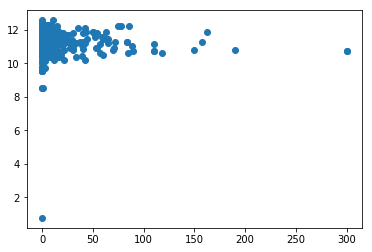

In [554]:
df_CEW_final = Multiple_Linear_Regression(df_CEW_final)

In [555]:
df_CEW_final.head()

farm  trap_count  year        date      tempf       dwpf  \
0      Pelham-G           0  2006  2006-06-19  70.977613  63.913169   
1  Litchfield-W           0  2006  2006-06-19  70.977613  63.913169   
2  Litchfield-M           0  2006  2006-06-19  70.977613  63.913169   
3   Merrimack-T           0  2006  2006-06-19  70.977613  63.913169   
4      Hollis-L           1  2006  2006-06-19  70.977613  63.913169   

        drct       feel  regression_count  
0  63.703704  71.301399         10.459989  
1  63.703704  71.301399         10.459989  
2  63.703704  71.301399         10.459989  
3  63.703704  71.301399         10.459989  
4  63.703704  71.301399         10.459989

In [556]:
#creating training and testign dataset 
mask = np.random.rand(len(df_CEW_final)) < 0.8
df_train_CEW = df_CEW_final[mask]
df_test_CEW = df_CEW_final[~mask]

In [557]:
df_train_CEW.head()

farm  trap_count  year        date      tempf       dwpf  \
0      Pelham-G           0  2006  2006-06-19  70.977613  63.913169   
1  Litchfield-W           0  2006  2006-06-19  70.977613  63.913169   
3   Merrimack-T           0  2006  2006-06-19  70.977613  63.913169   
4      Hollis-L           1  2006  2006-06-19  70.977613  63.913169   
5      Hollis-B           0  2006  2006-06-19  70.977613  63.913169   

        drct       feel  regression_count  
0  63.703704  71.301399         10.459989  
1  63.703704  71.301399         10.459989  
3  63.703704  71.301399         10.459989  
4  63.703704  71.301399         10.459989  
5  63.703704  71.301399         10.459989

In [558]:
print(len(df_train_CEW))
print(len(df_test_CEW))

2052
519


In [559]:
expr_CEW = """trap_count ~ tempf + dwpf + drct + feel"""

In [560]:
#Set up the X and y matrices
y_train, X_train = dmatrices(expr_CEW, df_CEW_final, return_type='dataframe')
y_test, X_test = dmatrices(expr_CEW, df_CEW_final, return_type='dataframe')

#y_train, X_train = dmatrices(expr_CEW, df_train_CEW, return_type='dataframe')
#y_test, X_test = dmatrices(expr_CEW, df_test_CEW, return_type='dataframe')

In [561]:
#X_test

In [562]:
#y_test

In [563]:
#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [564]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                 2571
Model:                            GLM   Df Residuals:                     2566
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -41041.
Date:                Wed, 06 May 2020   Deviance:                       75750.
Time:                        11:43:13   Pearson chi2:                 1.55e+05
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2900      0.042     54.923      0.000       2.208       2.372
tempf         -0.0907      0.008    -12.012      0.0

In [565]:
#Make some predictions on the test data set.
poisson_predictions = poisson_training_results.get_prediction(X_test)

In [566]:
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

           mean   mean_se  mean_ci_lower  mean_ci_upper
0     10.502287  0.121299      10.267216      10.742741
1     10.502287  0.121299      10.267216      10.742741
2     10.502287  0.121299      10.267216      10.742741
3     10.502287  0.121299      10.267216      10.742741
4     10.502287  0.121299      10.267216      10.742741
5     10.502287  0.121299      10.267216      10.742741
6     10.502287  0.121299      10.267216      10.742741
7     10.502287  0.121299      10.267216      10.742741
8     10.502287  0.121299      10.267216      10.742741
9     10.502287  0.121299      10.267216      10.742741
10    10.502287  0.121299      10.267216      10.742741
11    10.824663  0.103944      10.622843      11.030318
12    10.824663  0.103944      10.622843      11.030318
13    10.824663  0.103944      10.622843      11.030318
14    10.824663  0.103944      10.622843      11.030318
15    10.824663  0.103944      10.622843      11.030318
16    10.824663  0.103944      10.622843      11

In [567]:
#predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['trap_count']

In [568]:
poisson_count = predictions_summary_frame['mean']

In [569]:
#poisson_count

In [570]:
#print(actual_counts)

In [571]:
#Mlot the predicted counts versus the actual counts for the test data.
#fig = plt.figure()
#fig.suptitle('Predicted versus actual CEW pest counts ')
#predicted, = plt.plot(X_test.index, poisson_count, 'go-', label='Predicted counts')
#actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
#plt.legend(handles=[predicted, actual])
#plt.show()

<Figure size 432x288 with 0 Axes>

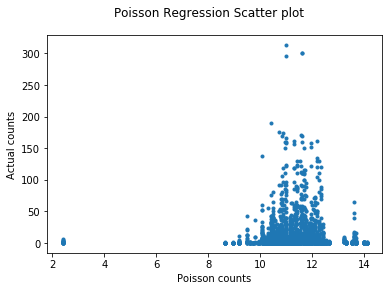

In [572]:
plt.clf()
fig = plt.figure()
fig.suptitle('Poisson Regression Scatter plot')
plt.scatter(x=poisson_count, y=actual_counts, marker='.')
plt.xlabel('Poisson counts')
plt.ylabel('Actual counts')
plt.show()

In [573]:
#writing dataframe into csv file

In [574]:
df_CEW_final['poisson_count'] = poisson_count

In [575]:
df_CEW_final.head()

farm  trap_count  year        date      tempf       dwpf  \
0      Pelham-G           0  2006  2006-06-19  70.977613  63.913169   
1  Litchfield-W           0  2006  2006-06-19  70.977613  63.913169   
2  Litchfield-M           0  2006  2006-06-19  70.977613  63.913169   
3   Merrimack-T           0  2006  2006-06-19  70.977613  63.913169   
4      Hollis-L           1  2006  2006-06-19  70.977613  63.913169   

        drct       feel  regression_count  poisson_count  
0  63.703704  71.301399         10.459989      10.502287  
1  63.703704  71.301399         10.459989      10.502287  
2  63.703704  71.301399         10.459989      10.502287  
3  63.703704  71.301399         10.459989      10.502287  
4  63.703704  71.301399         10.459989      10.502287

In [576]:
#writing into the csv file
df_CEW_final.to_csv("CEW_predicted_count.csv", index = False, sep = ',')

# Negative Binomial Regression - CEW

In [577]:
#print out the fitted rate vector
print(poisson_training_results.mu)

[10.50228707 10.50228707 10.50228707 ... 11.68078149 11.68078149
 11.68078149]


In [578]:
#Add the λ vector as a new column called 'BB_LAMBDA' to the Data Frame of the training data set
df_CEW_final_NB = df_CEW_final

In [579]:
df_CEW_final_NB.head()

farm  trap_count  year        date      tempf       dwpf  \
0      Pelham-G           0  2006  2006-06-19  70.977613  63.913169   
1  Litchfield-W           0  2006  2006-06-19  70.977613  63.913169   
2  Litchfield-M           0  2006  2006-06-19  70.977613  63.913169   
3   Merrimack-T           0  2006  2006-06-19  70.977613  63.913169   
4      Hollis-L           1  2006  2006-06-19  70.977613  63.913169   

        drct       feel  regression_count  poisson_count  
0  63.703704  71.301399         10.459989      10.502287  
1  63.703704  71.301399         10.459989      10.502287  
2  63.703704  71.301399         10.459989      10.502287  
3  63.703704  71.301399         10.459989      10.502287  
4  63.703704  71.301399         10.459989      10.502287

In [580]:
df_CEW_final_NB['LAMBDA'] = poisson_training_results.mu

In [581]:
df_CEW_final_NB.head()

farm  trap_count  year        date      tempf       dwpf  \
0      Pelham-G           0  2006  2006-06-19  70.977613  63.913169   
1  Litchfield-W           0  2006  2006-06-19  70.977613  63.913169   
2  Litchfield-M           0  2006  2006-06-19  70.977613  63.913169   
3   Merrimack-T           0  2006  2006-06-19  70.977613  63.913169   
4      Hollis-L           1  2006  2006-06-19  70.977613  63.913169   

        drct       feel  regression_count  poisson_count     LAMBDA  
0  63.703704  71.301399         10.459989      10.502287  10.502287  
1  63.703704  71.301399         10.459989      10.502287  10.502287  
2  63.703704  71.301399         10.459989      10.502287  10.502287  
3  63.703704  71.301399         10.459989      10.502287  10.502287  
4  63.703704  71.301399         10.459989      10.502287  10.502287

In [582]:
#add a derived column called 'AUX_OLS_DEP' to the pandas Data Frame. This new column will store the values of the dependent variable of the OLS regression
df_CEW_final_NB['AUX_OLS_DEP'] = df_CEW_final_NB.apply(lambda x: ((x['poisson_count'] - x['LAMBDA'])**2 - x['poisson_count']) / x['LAMBDA'], axis=1)



In [583]:
df_CEW_final_NB.head()

farm  trap_count  year        date      tempf       dwpf  \
0      Pelham-G           0  2006  2006-06-19  70.977613  63.913169   
1  Litchfield-W           0  2006  2006-06-19  70.977613  63.913169   
2  Litchfield-M           0  2006  2006-06-19  70.977613  63.913169   
3   Merrimack-T           0  2006  2006-06-19  70.977613  63.913169   
4      Hollis-L           1  2006  2006-06-19  70.977613  63.913169   

        drct       feel  regression_count  poisson_count     LAMBDA  \
0  63.703704  71.301399         10.459989      10.502287  10.502287   
1  63.703704  71.301399         10.459989      10.502287  10.502287   
2  63.703704  71.301399         10.459989      10.502287  10.502287   
3  63.703704  71.301399         10.459989      10.502287  10.502287   
4  63.703704  71.301399         10.459989      10.502287  10.502287   

   AUX_OLS_DEP  
0         -1.0  
1         -1.0  
2         -1.0  
3         -1.0  
4         -1.0

In [584]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [585]:
ols_expr = """AUX_OLS_DEP ~ LAMBDA - 1"""

In [586]:
#fitting the OLSR model
aux_olsr_results = smf.ols(ols_expr, df_CEW_final_NB).fit()

In [587]:
#Print the regression params
print(abs(aux_olsr_results.params[0]))


0.08788375329980906


In [588]:
#defining negative binomial regression model 
M2_NB_CEW = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha = abs(aux_olsr_results.params[0]))).fit()

In [589]:
print(M2_NB_CEW.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                 2571
Model:                            GLM   Df Residuals:                     2566
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20848.
Date:                Wed, 06 May 2020   Deviance:                       34263.
Time:                        11:43:14   Pearson chi2:                 7.77e+04
No. Iterations:                     9   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2529      0.059     38.145      0.000       2.137       2.369
tempf         -0.1147      0.010    -11.207      0.0

In [590]:
#predictions using NB2 model
#nb2_predictions = nb2_training_results.get_prediction(X_test)
M2_NB_CEW_pred = M2_NB_CEW.get_prediction(X_test)

In [591]:
#print out the predictions
predictions_summary_frame = M2_NB_CEW_pred.summary_frame()
print(predictions_summary_frame)

           mean   mean_se  mean_ci_lower  mean_ci_upper
0     10.398317  0.168510      10.073234      10.733890
1     10.398317  0.168510      10.073234      10.733890
2     10.398317  0.168510      10.073234      10.733890
3     10.398317  0.168510      10.073234      10.733890
4     10.398317  0.168510      10.073234      10.733890
5     10.398317  0.168510      10.073234      10.733890
6     10.398317  0.168510      10.073234      10.733890
7     10.398317  0.168510      10.073234      10.733890
8     10.398317  0.168510      10.073234      10.733890
9     10.398317  0.168510      10.073234      10.733890
10    10.398317  0.168510      10.073234      10.733890
11    10.793132  0.145126      10.512407      11.081355
12    10.793132  0.145126      10.512407      11.081355
13    10.793132  0.145126      10.512407      11.081355
14    10.793132  0.145126      10.512407      11.081355
15    10.793132  0.145126      10.512407      11.081355
16    10.793132  0.145126      10.512407      11

In [592]:
#plot the predicted counts versus the actual counts for the test data
NB_counts=predictions_summary_frame['mean']

In [593]:
#NB_counts

In [594]:
NB_actual_counts = y_test['trap_count']

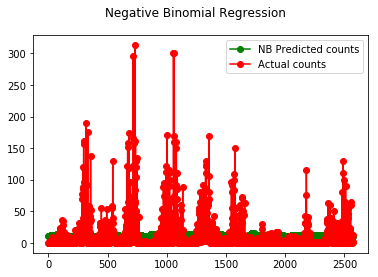

In [595]:
fig = plt.figure()
fig.suptitle('Negative Binomial Regression')
predicted, = plt.plot(X_test.index, NB_counts, 'go-', label='NB Predicted counts')
actual, = plt.plot(X_test.index, NB_actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

<Figure size 432x288 with 0 Axes>

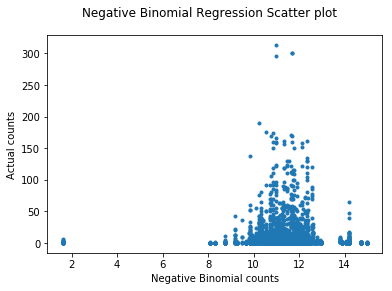

In [596]:
plt.clf()
fig = plt.figure()
fig.suptitle('Negative Binomial Regression Scatter plot')
plt.scatter(x=NB_counts, y=NB_actual_counts, marker='.')
plt.xlabel('Negative Binomial counts')
plt.ylabel('Actual counts')
plt.show()

In [597]:
df_CEW_final['NB_count'] = NB_counts

In [598]:
df_CEW_final.head()

farm  trap_count  year        date      tempf       dwpf  \
0      Pelham-G           0  2006  2006-06-19  70.977613  63.913169   
1  Litchfield-W           0  2006  2006-06-19  70.977613  63.913169   
2  Litchfield-M           0  2006  2006-06-19  70.977613  63.913169   
3   Merrimack-T           0  2006  2006-06-19  70.977613  63.913169   
4      Hollis-L           1  2006  2006-06-19  70.977613  63.913169   

        drct       feel  regression_count  poisson_count     LAMBDA  \
0  63.703704  71.301399         10.459989      10.502287  10.502287   
1  63.703704  71.301399         10.459989      10.502287  10.502287   
2  63.703704  71.301399         10.459989      10.502287  10.502287   
3  63.703704  71.301399         10.459989      10.502287  10.502287   
4  63.703704  71.301399         10.459989      10.502287  10.502287   

   AUX_OLS_DEP   NB_count  
0         -1.0  10.398317  
1         -1.0  10.398317  
2         -1.0  10.398317  
3         -1.0  10.398317  
4         -1.0  10.398317

In [599]:
df_CEW_final.drop('LAMBDA', axis=1, inplace=True)
df_CEW_final.drop('AUX_OLS_DEP', axis=1, inplace=True)

In [600]:
df_CEW_final.head(12)

farm  trap_count  year        date      tempf       dwpf  \
0         Pelham-G           0  2006  2006-06-19  70.977613  63.913169   
1     Litchfield-W           0  2006  2006-06-19  70.977613  63.913169   
2     Litchfield-M           0  2006  2006-06-19  70.977613  63.913169   
3      Merrimack-T           0  2006  2006-06-19  70.977613  63.913169   
4         Hollis-L           1  2006  2006-06-19  70.977613  63.913169   
5         Hollis-B           0  2006  2006-06-19  70.977613  63.913169   
6         Hollis-K           0  2006  2006-06-19  70.977613  63.913169   
7        Milford-S           0  2006  2006-06-19  70.977613  63.913169   
8         Antrim-T           0  2006  2006-06-19  70.977613  63.913169   
9          Mason-B           0  2006  2006-06-19  70.977613  63.913169   
10  Peterborough-R           0  2006  2006-06-19  70.977613  63.913169   
11        Pelham-G           0  2006  2006-06-26  71.243468  65.095887   

         drct       feel  regression_count  poisson_count   NB_count  
0   63.703704  71.301399         10.459989      10.502287  10.398317  
1   63.703704  71.301399         10.459989      10.502287  10.398317  
2   63.703704  71.301399         10.459989      10.502287  10.398317  
3   63.703704  71.301399         10.459989      10.502287  10.398317  
4   63.703704  71.301399         10.459989      10.502287  10.398317  
5   63.703704  71.301399         10.459989      10.502287  10.398317  
6   63.703704  71.301399         10.459989      10.502287  10.398317  
7   63.703704  71.301399         10.459989      10.502287  10.398317  
8   63.703704  71.301399         10.459989      10.502287  10.398317  
9   63.703704  71.301399         10.459989      10.502287  10.398317  
10  63.703704  71.301399         10.459989      10.502287  10.398317  
11  84.233871  71.733347         11.033953      10.824663  10.793132

In [601]:
#writing into the csv file
df_CEW_final.to_csv("CEW_predicted_count.csv", index = False, sep = ',')

# Poisson Regression Based on Each Farm

In [602]:
#1 for the farm Pelham-G
df_CEW_pelham = df_CEW_final.loc[df_CEW_final['farm'] == 'Pelham-G']

#2 for the farm Pelham-G
df_CEW_LitchfieldW = df_CEW_final.loc[df_CEW_final['farm'] == 'Litchfield-W']

#3 for the farm Pelham-G
df_CEW_LitchfieldM = df_CEW_final.loc[df_CEW_final['farm'] == 'Litchfield-M']

#4 for the farm Pelham-G
df_CEW_MerrimackT = df_CEW_final.loc[df_CEW_final['farm'] == 'Merrimack-T']

#5 for the farm Pelham-G
df_CEW_HollisL = df_CEW_final.loc[df_CEW_final['farm'] == 'Hollis-L']

#6 for the farm Pelham-G
df_CEW_HollisB = df_CEW_final.loc[df_CEW_final['farm'] == 'Hollis-B']

#7 for the farm Pelham-G
df_CEW_HollisK = df_CEW_final.loc[df_CEW_final['farm'] == 'Hollis-K']

#8 for the farm Pelham-G
df_CEW_MilfordS = df_CEW_final.loc[df_CEW_final['farm'] == 'Milford-S']

#9 for the farm Pelham-G
df_CEW_AntrimT = df_CEW_final.loc[df_CEW_final['farm'] == 'Antrim-T']

#10 for the farm Pelham-G
df_CEW_MasonB = df_CEW_final.loc[df_CEW_final['farm'] == 'Mason-B']

#11 for the farm Pelham-G
df_CEW_PeterboroughR = df_CEW_final.loc[df_CEW_final['farm'] == 'Peterborough-R']

In [603]:
df_CEW_pelham.head()

farm  trap_count  year        date      tempf       dwpf        drct  \
0   Pelham-G           0  2006  2006-06-19  70.977613  63.913169   63.703704   
11  Pelham-G           0  2006  2006-06-26  71.243468  65.095887   84.233871   
22  Pelham-G           0  2006  2006-07-03  71.056485  59.203758  127.515152   
33  Pelham-G           0  2006  2006-07-10  71.830909  66.491782   59.745455   
45  Pelham-G           0  2006  2006-07-17  73.200175  66.515808  101.004367   

         feel  regression_count  poisson_count   NB_count  
0   71.301399         10.459989      10.502287  10.398317  
11  71.733347         11.033953      10.824663  10.793132  
22  71.263273         11.528981      12.268939  12.518481  
33  72.608255         10.756261      10.622663  10.572345  
45  74.150786         11.687964      11.674616  11.854049

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  121
Model:                            GLM   Df Residuals:                      116
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -821.31
Date:                Wed, 06 May 2020   Deviance:                       1433.0
Time:                        11:43:15   Pearson chi2:                 2.42e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0062      0.370     -2.719      0.007      -1.732      -0.281
tempf         -0.0256      0.040     -0.648      0.5

<Figure size 432x288 with 0 Axes>

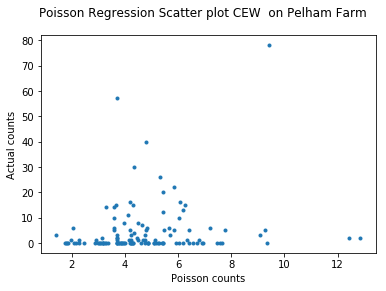

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [604]:
df_CEW_pelham = Poisson_Regression(df_CEW_pelham," CEW ", "Pelham ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   71
Model:                            GLM   Df Residuals:                       66
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1624.1
Date:                Wed, 06 May 2020   Deviance:                       2949.4
Time:                        11:43:15   Pearson chi2:                 3.27e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1329      0.262     31.007      0.000       7.619       8.647
tempf          0.0215      0.022      0.972      0.3

<Figure size 432x288 with 0 Axes>

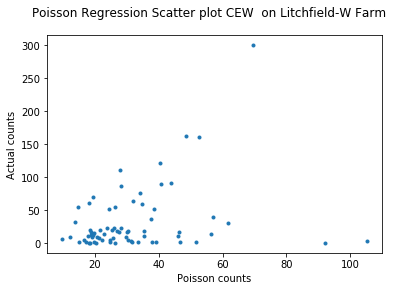

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [605]:
#2 for the farm Pelham-G
#df_CEW_LitchfieldW = df_CEW_final.loc[df_CEW_final['farm'] == 'Litchfield-W']
df_CEW_LitchfieldW = Poisson_Regression(df_CEW_LitchfieldW ," CEW ", "Litchfield-W ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  147
Model:                            GLM   Df Residuals:                      142
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2056.5
Date:                Wed, 06 May 2020   Deviance:                       3762.8
Time:                        11:43:15   Pearson chi2:                 7.16e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3816      0.181     13.123      0.000       2.026       2.737
tempf         -0.2770      0.045     -6.196      0.0

<Figure size 432x288 with 0 Axes>

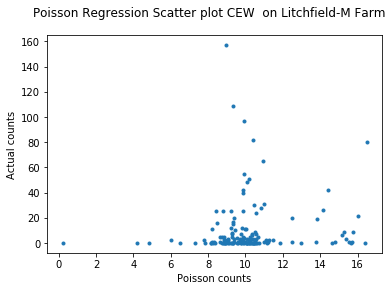

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [606]:
#3 for the farm Pelham-G
#df_CEW_LitchfieldM = df_CEW_final.loc[df_CEW_final['farm'] == 'Litchfield-M']
df_CEW_LitchfieldM = Poisson_Regression(df_CEW_LitchfieldM," CEW ", "Litchfield-M ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   57
Model:                            GLM   Df Residuals:                       52
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -261.86
Date:                Wed, 06 May 2020   Deviance:                       442.06
Time:                        11:43:15   Pearson chi2:                 1.00e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1511      1.593      1.978      0.048       0.028       6.274
tempf         -0.8531      0.300     -2.848      0.0

<Figure size 432x288 with 0 Axes>

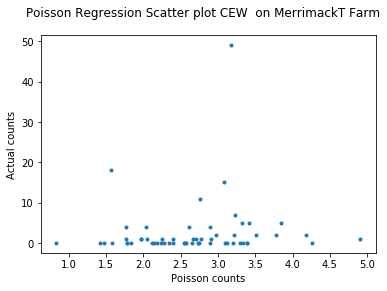

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [607]:
#4 for the farm Pelham-G
#df_CEW_MerrimackT = df_CEW_final.loc[df_CEW_final['farm'] == 'Merrimack-T']
df_CEW_MerrimackT = Poisson_Regression(df_CEW_MerrimackT," CEW ", "MerrimackT ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  131
Model:                            GLM   Df Residuals:                      126
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1651.0
Date:                Wed, 06 May 2020   Deviance:                       2932.4
Time:                        11:43:16   Pearson chi2:                 4.81e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4252      0.176     13.742      0.000       2.079       2.771
tempf         -0.1507      0.033     -4.523      0.0

<Figure size 432x288 with 0 Axes>

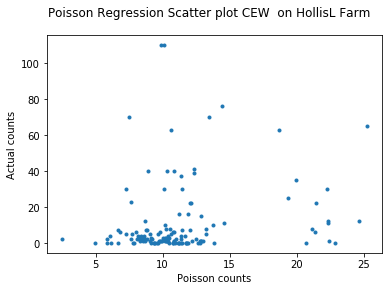

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [608]:
#5 for the farm Pelham-G
#df_CEW_HollisL = df_CEW_final.loc[df_CEW_final['farm'] == 'Hollis-L']
df_CEW_HollisL = Poisson_Regression(df_CEW_HollisL," CEW ", "HollisL ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   62
Model:                            GLM   Df Residuals:                       57
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1648.7
Date:                Wed, 06 May 2020   Deviance:                       3091.3
Time:                        11:43:16   Pearson chi2:                 4.36e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6484      0.496      7.357      0.000       2.676       4.620
tempf         -0.4368      0.089     -4.884      0.0

<Figure size 432x288 with 0 Axes>

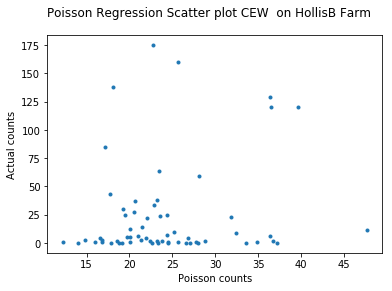

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [609]:
#6 for the farm Pelham-G
#df_CEW_HollisB = df_CEW_final.loc[df_CEW_final['farm'] == 'Hollis-B']
df_CEW_HollisB = Poisson_Regression(df_CEW_HollisB," CEW ", "HollisB ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  150
Model:                            GLM   Df Residuals:                      145
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2617.0
Date:                Wed, 06 May 2020   Deviance:                       4826.3
Time:                        11:43:16   Pearson chi2:                 8.15e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2953      0.161      8.045      0.000       0.980       1.611
tempf         -0.1764      0.033     -5.369      0.0

<Figure size 432x288 with 0 Axes>

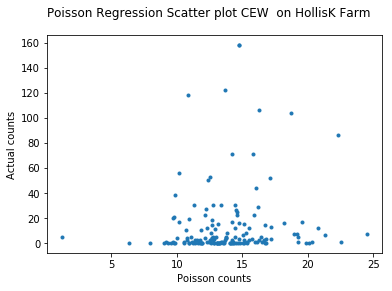

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [610]:
#7 for the farm Pelham-G
#df_CEW_HollisK = df_CEW_final.loc[df_CEW_final['farm'] == 'Hollis-K']
df_CEW_HollisK = Poisson_Regression(df_CEW_HollisK," CEW ", "HollisK ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  133
Model:                            GLM   Df Residuals:                      128
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2587.4
Date:                Wed, 06 May 2020   Deviance:                       4824.0
Time:                        11:43:16   Pearson chi2:                 9.66e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4241      0.168     20.416      0.000       3.095       3.753
tempf         -0.0154      0.027     -0.567      0.5

<Figure size 432x288 with 0 Axes>

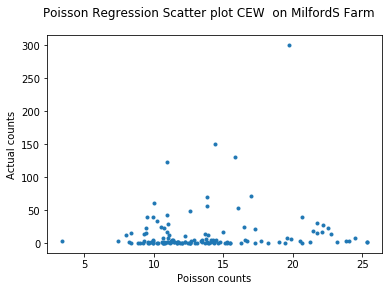

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [611]:
#8 for the farm Pelham-G
#df_CEW_MilfordS = df_CEW_final.loc[df_CEW_final['farm'] == 'Milford-S']
df_CEW_MilfordS  = Poisson_Regression(df_CEW_MilfordS ," CEW ", "MilfordS ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  142
Model:                            GLM   Df Residuals:                      137
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1251.4
Date:                Wed, 06 May 2020   Deviance:                       2179.9
Time:                        11:43:16   Pearson chi2:                 3.63e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9277      0.261      3.557      0.000       0.416       1.439
tempf         -0.0284      0.039     -0.733      0.4

<Figure size 432x288 with 0 Axes>

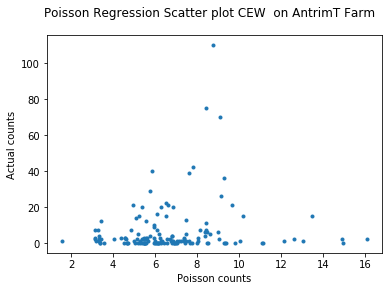

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [612]:
#9 for the farm Pelham-G
#df_CEW_AntrimT = df_CEW_final.loc[df_CEW_final['farm'] == 'Antrim-T']
df_CEW_AntrimT = Poisson_Regression(df_CEW_AntrimT," CEW ", "AntrimT ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  121
Model:                            GLM   Df Residuals:                      116
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1691.4
Date:                Wed, 06 May 2020   Deviance:                       3035.8
Time:                        11:43:17   Pearson chi2:                 4.65e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1164      0.175     12.119      0.000       1.774       2.459
tempf         -0.0215      0.049     -0.434      0.6

<Figure size 432x288 with 0 Axes>

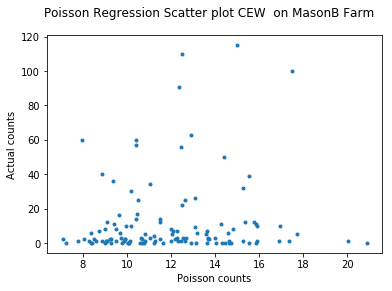

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [613]:
#10 for the farm Pelham-G
#df_CEW_MasonB = df_CEW_final.loc[df_CEW_final['farm'] == 'Mason-B']
df_CEW_MasonB = Poisson_Regression(df_CEW_MasonB," CEW ", "MasonB ")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   62
Model:                            GLM   Df Residuals:                       57
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -323.90
Date:                Wed, 06 May 2020   Deviance:                       583.82
Time:                        11:43:17   Pearson chi2:                 1.36e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.5814      0.688     -5.204      0.000      -4.930      -2.233
tempf         -0.3741      0.173     -2.164      0.0

<Figure size 432x288 with 0 Axes>

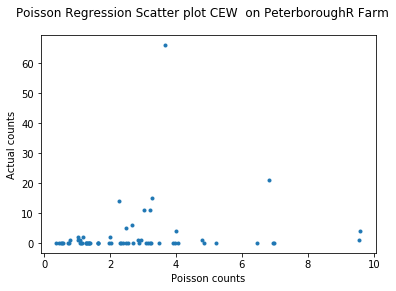

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [614]:
#11 for the farm Pelham-G
#df_CEW_PeterboroughR = df_CEW_final.loc[df_CEW_final['farm'] == 'Peterborough-R']
df_CEW_PeterboroughR  = Poisson_Regression(df_CEW_PeterboroughR ," CEW ", "PeterboroughR ")

In [615]:
df_CEW_pelham.head()

farm  trap_count  year        date      tempf       dwpf        drct  \
0   Pelham-G           0  2006  2006-06-19  70.977613  63.913169   63.703704   
11  Pelham-G           0  2006  2006-06-26  71.243468  65.095887   84.233871   
22  Pelham-G           0  2006  2006-07-03  71.056485  59.203758  127.515152   
33  Pelham-G           0  2006  2006-07-10  71.830909  66.491782   59.745455   
45  Pelham-G           0  2006  2006-07-17  73.200175  66.515808  101.004367   

         feel  regression_count  poisson_count   NB_count  poisson_count_farm  
0   71.301399         10.459989      10.502287  10.398317            3.176978  
11  71.733347         11.033953      10.824663  10.793132            3.996585  
22  71.263273         11.528981      12.268939  12.518481            6.933632  
33  72.608255         10.756261      10.622663  10.572345            3.089388  
45  74.150786         11.687964      11.674616  11.854049            5.179942

In [616]:
df_CEW_final['poisson_count_farm'] = 0

In [617]:
df_CEW_final.head()

farm  trap_count  year        date      tempf       dwpf  \
0      Pelham-G           0  2006  2006-06-19  70.977613  63.913169   
1  Litchfield-W           0  2006  2006-06-19  70.977613  63.913169   
2  Litchfield-M           0  2006  2006-06-19  70.977613  63.913169   
3   Merrimack-T           0  2006  2006-06-19  70.977613  63.913169   
4      Hollis-L           1  2006  2006-06-19  70.977613  63.913169   

        drct       feel  regression_count  poisson_count   NB_count  \
0  63.703704  71.301399         10.459989      10.502287  10.398317   
1  63.703704  71.301399         10.459989      10.502287  10.398317   
2  63.703704  71.301399         10.459989      10.502287  10.398317   
3  63.703704  71.301399         10.459989      10.502287  10.398317   
4  63.703704  71.301399         10.459989      10.502287  10.398317   

   poisson_count_farm  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

In [618]:
#1
#df_CEW_final['poisson_count_farm'] = df_CEW_pelham['poisson_count_farm']
#df_CEW_final.join(df_CEW_pelham.set_index('poisson_count_farm').poisson_count_farm)

#df_CEW_final['poisson_count_farm'] = df_CEW_pelham.loc[df_CEW_pelham.farm == 'Pelham-G', ['poisson_count_farm']]

df_CEW_final.loc[df_CEW_final.farm == 'Pelham-G', ['poisson_count_farm']] = df_CEW_pelham.loc[df_CEW_pelham.farm == 'Pelham-G', ['poisson_count_farm']]



In [619]:
df_CEW_final.head()

farm  trap_count  year        date      tempf       dwpf  \
0      Pelham-G           0  2006  2006-06-19  70.977613  63.913169   
1  Litchfield-W           0  2006  2006-06-19  70.977613  63.913169   
2  Litchfield-M           0  2006  2006-06-19  70.977613  63.913169   
3   Merrimack-T           0  2006  2006-06-19  70.977613  63.913169   
4      Hollis-L           1  2006  2006-06-19  70.977613  63.913169   

        drct       feel  regression_count  poisson_count   NB_count  \
0  63.703704  71.301399         10.459989      10.502287  10.398317   
1  63.703704  71.301399         10.459989      10.502287  10.398317   
2  63.703704  71.301399         10.459989      10.502287  10.398317   
3  63.703704  71.301399         10.459989      10.502287  10.398317   
4  63.703704  71.301399         10.459989      10.502287  10.398317   

   poisson_count_farm  
0            3.176978  
1            0.000000  
2            0.000000  
3            0.000000  
4            0.000000

In [620]:
df_CEW_LitchfieldW.head()

farm  trap_count  year        date      tempf       dwpf  \
1   Litchfield-W           0  2006  2006-06-19  70.977613  63.913169   
12  Litchfield-W           0  2006  2006-06-26  71.243468  65.095887   
23  Litchfield-W           3  2006  2006-07-03  71.056485  59.203758   
34  Litchfield-W           1  2006  2006-07-10  71.830909  66.491782   
46  Litchfield-W           1  2006  2006-07-17  73.200175  66.515808   

          drct       feel  regression_count  poisson_count   NB_count  \
1    63.703704  71.301399         10.459989      10.502287  10.398317   
12   84.233871  71.733347         11.033953      10.824663  10.793132   
23  127.515152  71.263273         11.528981      12.268939  12.518481   
34   59.745455  72.608255         10.756261      10.622663  10.572345   
46  101.004367  74.150786         11.687964      11.674616  11.854049   

    poisson_count_farm  
1            26.307240  
12           18.207249  
23           31.192923  
34           19.725128  
46           15.029908

In [621]:
#2
#df_CEW_final['poisson_count_farm'] = df_CEW_LitchfieldW['poisson_count_farm']

#df_CEW_final.ix[df_CEW_final.farm == 'Litchfield-W', ['poisson_count_farm']] = df_CEW_LitchfieldW.ix[df_CEW_LitchfieldW.farm == 'Litchfield-W', ['poisson_count_farm']]

df_CEW_final.loc[df_CEW_final.farm == 'Litchfield-W', ['poisson_count_farm']] = df_CEW_LitchfieldW.loc[df_CEW_LitchfieldW.farm == 'Litchfield-W', ['poisson_count_farm']]




In [622]:
df_CEW_final

farm  trap_count  year        date      tempf       dwpf  \
0           Pelham-G           0  2006  2006-06-19  70.977613  63.913169   
1       Litchfield-W           0  2006  2006-06-19  70.977613  63.913169   
2       Litchfield-M           0  2006  2006-06-19  70.977613  63.913169   
3        Merrimack-T           0  2006  2006-06-19  70.977613  63.913169   
4           Hollis-L           1  2006  2006-06-19  70.977613  63.913169   
5           Hollis-B           0  2006  2006-06-19  70.977613  63.913169   
6           Hollis-K           0  2006  2006-06-19  70.977613  63.913169   
7          Milford-S           0  2006  2006-06-19  70.977613  63.913169   
8           Antrim-T           0  2006  2006-06-19  70.977613  63.913169   
9            Mason-B           0  2006  2006-06-19  70.977613  63.913169   
10    Peterborough-R           0  2006  2006-06-19  70.977613  63.913169   
11          Pelham-G           0  2006  2006-06-26  71.243468  65.095887   
12      Litchfield-W           0  2006  2006-06-26  71.243468  65.095887   
13      Litchfield-M           0  2006  2006-06-26  71.243468  65.095887   
14       Merrimack-T           0  2006  2006-06-26  71.243468  65.095887   
15          Hollis-L           1  2006  2006-06-26  71.243468  65.095887   
16          Hollis-B           0  2006  2006-06-26  71.243468  65.095887   
17          Hollis-K           0  2006  2006-06-26  71.243468  65.095887   
18         Milford-S           0  2006  2006-06-26  71.243468  65.095887   
19          Antrim-T           0  2006  2006-06-26  71.243468  65.095887   
20           Mason-B           0  2006  2006-06-26  71.243468  65.095887   
21    Peterborough-R           0  2006  2006-06-26  71.243468  65.095887   
22          Pelham-G           0  2006  2006-07-03  71.056485  59.203758   
23      Litchfield-W           3  2006  2006-07-03  71.056485  59.203758   
24      Litchfield-M           0  2006  2006-07-03  71.056485  59.203758   
25       Merrimack-T           0  2006  2006-07-03  71.056485  59.203758   
26          Hollis-L           4  2006  2006-07-03  71.056485  59.203758   
27          Hollis-B          10  2006  2006-07-03  71.056485  59.203758   
28          Hollis-K           1  2006  2006-07-03  71.056485  59.203758   
29         Milford-S           3  2006  2006-07-03  71.056485  59.203758   
...              ...         ...   ...         ...        ...        ...   
2541         Weare-D           0  2018  2018-09-17   7.760753   7.281021   
2542     NewBoston-D           2  2018  2018-09-17   7.760753   7.281021   
2543    NewLondon-SL           5  2018  2018-09-17   7.760753   7.281021   
2544    Litchfield-M          21  2018  2018-09-24   6.692446   6.180576   
2545   Litchfield-W1          10  2018  2018-09-24   6.692446   6.180576   
2546        Hudson-S           8  2018  2018-09-24   6.692446   6.180576   
2547       Milford-L          20  2018  2018-09-24   6.692446   6.180576   
2548        Hollis-K          12  2018  2018-09-24   6.692446   6.180576   
2549       Hollis-B2           8  2018  2018-09-24   6.692446   6.180576   
2550    Hollis-JL-Pl          23  2018  2018-09-24   6.692446   6.180576   
2551     Hollis-JL-T          60  2018  2018-09-24   6.692446   6.180576   
2552        Hollis-L          65  2018  2018-09-24   6.692446   6.180576   
2553        Antrim-T           1  2018  2018-09-24   6.692446   6.180576   
2554    NewIpswich-B           1  2018  2018-09-24   6.692446   6.180576   
2555         Mason-B           5  2018  2018-09-24   6.692446   6.180576   
2556       Milford-M           4  2018  2018-09-24   6.692446   6.180576   
2557       Concord-A           3  2018  2018-09-24   6.692446   6.180576   
2558         Weare-I           1  2018  2018-09-24   6.692446   6.180576   
2559         Weare-D           2  2018  2018-09-24   6.692446   6.180576   
2560    NewLondon-SL           1  2018  2018-09-24   6.692446   6.180576   
2561    Litchfield-M           6  2018  2018-10-01   7.799536   

In [623]:
#3
#df_CEW_final['poisson_count_farm'] = df_CEW_LitchfieldM['poisson_count_farm']
df_CEW_final.loc[df_CEW_final.farm == 'Litchfield-M', ['poisson_count_farm']] = df_CEW_LitchfieldM.loc[df_CEW_LitchfieldM.farm == 'Litchfield-M', ['poisson_count_farm']]



In [624]:
df_CEW_final.head(15)

farm  trap_count  year        date      tempf       dwpf  \
0         Pelham-G           0  2006  2006-06-19  70.977613  63.913169   
1     Litchfield-W           0  2006  2006-06-19  70.977613  63.913169   
2     Litchfield-M           0  2006  2006-06-19  70.977613  63.913169   
3      Merrimack-T           0  2006  2006-06-19  70.977613  63.913169   
4         Hollis-L           1  2006  2006-06-19  70.977613  63.913169   
5         Hollis-B           0  2006  2006-06-19  70.977613  63.913169   
6         Hollis-K           0  2006  2006-06-19  70.977613  63.913169   
7        Milford-S           0  2006  2006-06-19  70.977613  63.913169   
8         Antrim-T           0  2006  2006-06-19  70.977613  63.913169   
9          Mason-B           0  2006  2006-06-19  70.977613  63.913169   
10  Peterborough-R           0  2006  2006-06-19  70.977613  63.913169   
11        Pelham-G           0  2006  2006-06-26  71.243468  65.095887   
12    Litchfield-W           0  2006  2006-06-26  71.243468  65.095887   
13    Litchfield-M           0  2006  2006-06-26  71.243468  65.095887   
14     Merrimack-T           0  2006  2006-06-26  71.243468  65.095887   

         drct       feel  regression_count  poisson_count   NB_count  \
0   63.703704  71.301399         10.459989      10.502287  10.398317   
1   63.703704  71.301399         10.459989      10.502287  10.398317   
2   63.703704  71.301399         10.459989      10.502287  10.398317   
3   63.703704  71.301399         10.459989      10.502287  10.398317   
4   63.703704  71.301399         10.459989      10.502287  10.398317   
5   63.703704  71.301399         10.459989      10.502287  10.398317   
6   63.703704  71.301399         10.459989      10.502287  10.398317   
7   63.703704  71.301399         10.459989      10.502287  10.398317   
8   63.703704  71.301399         10.459989      10.502287  10.398317   
9   63.703704  71.301399         10.459989      10.502287  10.398317   
10  63.703704  71.301399         10.459989      10.502287  10.398317   
11  84.233871  71.733347         11.033953      10.824663  10.793132   
12  84.233871  71.733347         11.033953      10.824663  10.793132   
13  84.233871  71.733347         11.033953      10.824663  10.793132   
14  84.233871  71.733347         11.033953      10.824663  10.793132   

    poisson_count_farm  
0             3.176978  
1            26.307240  
2             9.087069  
3             0.000000  
4             0.000000  
5             0.000000  
6             0.000000  
7             0.000000  
8             0.000000  
9             0.000000  
10            0.000000  
11            3.996585  
12           18.207249  
13           10.241416  
14            0.000000

In [625]:
#4
#df_CEW_final['poisson_count_farm'] = df_CEW_MerrimackT['poisson_count_farm']
df_CEW_final.loc[df_CEW_final.farm == 'Merrimack-T', ['poisson_count_farm']] = df_CEW_MerrimackT.loc[df_CEW_MerrimackT.farm == 'Merrimack-T', ['poisson_count_farm']]



In [626]:
#5
#df_CEW_final['poisson_count_farm'] = df_CEW_HollisL['poisson_count_farm']
df_CEW_final.loc[df_CEW_final.farm == 'Hollis-L', ['poisson_count_farm']] = df_CEW_HollisL.loc[df_CEW_HollisL.farm == 'Hollis-L', ['poisson_count_farm']]




In [627]:
#6
#df_CEW_final['poisson_count_farm'] = df_CEW_HollisB['poisson_count_farm']
df_CEW_final.loc[df_CEW_final.farm == 'Hollis-B', ['poisson_count_farm']] = df_CEW_HollisB.loc[df_CEW_HollisB.farm == 'Hollis-B', ['poisson_count_farm']]



In [628]:
#7
#df_CEW_final['poisson_count_farm'] = df_CEW_HollisK['poisson_count_farm']
df_CEW_final.loc[df_CEW_final.farm == 'Hollis-K', ['poisson_count_farm']] = df_CEW_HollisK.loc[df_CEW_HollisK.farm == 'Hollis-K', ['poisson_count_farm']]



In [629]:
#8
#df_CEW_final['poisson_count_farm'] = df_CEW_MilfordS['poisson_count_farm']
df_CEW_final.loc[df_CEW_final.farm == 'Milford-S', ['poisson_count_farm']] = df_CEW_MilfordS.loc[df_CEW_MilfordS.farm == 'Milford-S', ['poisson_count_farm']]




In [630]:
#9
#df_CEW_final['poisson_count_farm'] = df_CEW_AntrimT['poisson_count_farm']
df_CEW_final.loc[df_CEW_final.farm == 'Antrim-T', ['poisson_count_farm']] = df_CEW_AntrimT.loc[df_CEW_AntrimT.farm == 'Antrim-T', ['poisson_count_farm']]



In [631]:
#10
#df_CEW_final['poisson_count_farm'] = df_CEW_MasonB['poisson_count_farm']
df_CEW_final.loc[df_CEW_final.farm == 'Mason-B', ['poisson_count_farm']] = df_CEW_MasonB.loc[df_CEW_MasonB.farm == 'Mason-B', ['poisson_count_farm']]



In [632]:
#11
#df_CEW_final['poisson_count_farm'] = df_CEW_PeterboroughR['poisson_count_farm']
df_CEW_final.loc[df_CEW_final.farm == 'Peterborough-R', ['poisson_count_farm']] = df_CEW_PeterboroughR.loc[df_CEW_PeterboroughR.farm == 'Peterborough-R', ['poisson_count_farm']]



In [633]:
df_CEW_final['regression_count'] = df_CEW_final['regression_count'].apply(np.int64)
df_CEW_final['poisson_count'] = df_CEW_final['poisson_count'].apply(np.int64)
df_CEW_final['NB_count'] = df_CEW_final['NB_count'].apply(np.int64)
df_CEW_final['poisson_count_farm'] = df_CEW_final['poisson_count_farm'].apply(np.int64)


In [634]:

df_CEW_final

farm  trap_count  year        date      tempf       dwpf  \
0           Pelham-G           0  2006  2006-06-19  70.977613  63.913169   
1       Litchfield-W           0  2006  2006-06-19  70.977613  63.913169   
2       Litchfield-M           0  2006  2006-06-19  70.977613  63.913169   
3        Merrimack-T           0  2006  2006-06-19  70.977613  63.913169   
4           Hollis-L           1  2006  2006-06-19  70.977613  63.913169   
5           Hollis-B           0  2006  2006-06-19  70.977613  63.913169   
6           Hollis-K           0  2006  2006-06-19  70.977613  63.913169   
7          Milford-S           0  2006  2006-06-19  70.977613  63.913169   
8           Antrim-T           0  2006  2006-06-19  70.977613  63.913169   
9            Mason-B           0  2006  2006-06-19  70.977613  63.913169   
10    Peterborough-R           0  2006  2006-06-19  70.977613  63.913169   
11          Pelham-G           0  2006  2006-06-26  71.243468  65.095887   
12      Litchfield-W           0  2006  2006-06-26  71.243468  65.095887   
13      Litchfield-M           0  2006  2006-06-26  71.243468  65.095887   
14       Merrimack-T           0  2006  2006-06-26  71.243468  65.095887   
15          Hollis-L           1  2006  2006-06-26  71.243468  65.095887   
16          Hollis-B           0  2006  2006-06-26  71.243468  65.095887   
17          Hollis-K           0  2006  2006-06-26  71.243468  65.095887   
18         Milford-S           0  2006  2006-06-26  71.243468  65.095887   
19          Antrim-T           0  2006  2006-06-26  71.243468  65.095887   
20           Mason-B           0  2006  2006-06-26  71.243468  65.095887   
21    Peterborough-R           0  2006  2006-06-26  71.243468  65.095887   
22          Pelham-G           0  2006  2006-07-03  71.056485  59.203758   
23      Litchfield-W           3  2006  2006-07-03  71.056485  59.203758   
24      Litchfield-M           0  2006  2006-07-03  71.056485  59.203758   
25       Merrimack-T           0  2006  2006-07-03  71.056485  59.203758   
26          Hollis-L           4  2006  2006-07-03  71.056485  59.203758   
27          Hollis-B          10  2006  2006-07-03  71.056485  59.203758   
28          Hollis-K           1  2006  2006-07-03  71.056485  59.203758   
29         Milford-S           3  2006  2006-07-03  71.056485  59.203758   
...              ...         ...   ...         ...        ...        ...   
2541         Weare-D           0  2018  2018-09-17   7.760753   7.281021   
2542     NewBoston-D           2  2018  2018-09-17   7.760753   7.281021   
2543    NewLondon-SL           5  2018  2018-09-17   7.760753   7.281021   
2544    Litchfield-M          21  2018  2018-09-24   6.692446   6.180576   
2545   Litchfield-W1          10  2018  2018-09-24   6.692446   6.180576   
2546        Hudson-S           8  2018  2018-09-24   6.692446   6.180576   
2547       Milford-L          20  2018  2018-09-24   6.692446   6.180576   
2548        Hollis-K          12  2018  2018-09-24   6.692446   6.180576   
2549       Hollis-B2           8  2018  2018-09-24   6.692446   6.180576   
2550    Hollis-JL-Pl          23  2018  2018-09-24   6.692446   6.180576   
2551     Hollis-JL-T          60  2018  2018-09-24   6.692446   6.180576   
2552        Hollis-L          65  2018  2018-09-24   6.692446   6.180576   
2553        Antrim-T           1  2018  2018-09-24   6.692446   6.180576   
2554    NewIpswich-B           1  2018  2018-09-24   6.692446   6.180576   
2555         Mason-B           5  2018  2018-09-24   6.692446   6.180576   
2556       Milford-M           4  2018  2018-09-24   6.692446   6.180576   
2557       Concord-A           3  2018  2018-09-24   6.692446   6.180576   
2558         Weare-I           1  2018  2018-09-24   6.692446   6.180576   
2559         Weare-D           2  2018  2018-09-24   6.692446   6.180576   
2560    NewLondon-SL           1  2018  2018-09-24   6.692446   6.180576   
2561    Litchfield-M           6  2018  2018-10-01   7.799536   

In [635]:
#writing into the csv file
df_CEW_final.to_csv("CEW_predicted_count.csv", index = False, sep = ',')

# Negative Binomial Regression Based on Each Farm

# selecting weather dataframe within the date range - ECB Pest

In [636]:
print(search_ecb_STdate)
print(search_ecb_ENDdate)

2006-06-19 00:00:00
2018-10-15 00:00:00


In [637]:
df_equation_ECB = df_equation.loc[(df_equation['valid'] >= search_ecb_STdate) & (df_equation['valid'] <= search_ecb_ENDdate), :]

In [638]:
#need to get all the columns from here and sum up fro every week 
#select date and each column, and find the average for each column
df_tempf_ECB = df_equation_ECB[['tmpf','dwpf', 'drct','feel','valid']]
df_tempf_ECB["tmpf"] = df_tempf_ECB["tmpf"].fillna(0)
df_tempf_ECB["dwpf"] = df_tempf_ECB["dwpf"].fillna(0)
df_tempf_ECB["drct"] = df_tempf_ECB["drct"].fillna(0)
df_tempf_ECB["feel"] = df_tempf_ECB["feel"].fillna(0)

In [639]:
#calling getweekly_temperature
ECB_weather_data_dic = {}
getweekly_temperature(df_tempf_ECB,ECB_weather_data_dic)

total temperature index  642
total weeks:  47922


In [640]:
df_ECB_weather = pd.DataFrame(ECB_weather_data_dic)

In [641]:
df_ECB['date'] = df_ECB['date'].dt.date

In [642]:
#combining weather data and pest count data based on the date -----
#creating data frame needed for equation
df_ECB_weather['date'] = pd.to_datetime(df_ECB_weather['date'])
df_ECB_weather['date'] = df_ECB_weather['date'].dt.date
df_ECB_final = df_ECB.merge(df_ECB_weather, on='date')

In [643]:
df_ECB_final.head()

farm  trap_count  year        date      tempf       dwpf  \
0  Litchfield-W          16  2006  2006-06-19  70.977613  63.913169   
1      Hollis-B           7  2006  2006-06-19  70.977613  63.913169   
2       Mason-B          11  2006  2006-06-19  70.977613  63.913169   
3  Litchfield-W          25  2006  2006-06-26  71.243468  65.095887   
4      Hollis-B          31  2006  2006-06-26  71.243468  65.095887   

        drct       feel  
0  63.703704  71.301399  
1  63.703704  71.301399  
2  63.703704  71.301399  
3  84.233871  71.733347  
4  84.233871  71.733347

# predicting trap counts :::: ECB pest

In [644]:
#creating training and testign dataset 
mask_ecb = np.random.rand(len(df_ECB_final)) < 0.8
df_train_ECB = df_ECB_final[mask_ecb]
df_test_ECB = df_ECB_final[~mask_ecb]

In [194]:
expr_ECB = """trap_count ~ tempf + dwpf + drct + feel"""

In [197]:
#Set up the X and y matrices
y_train_ecb, X_train_ecb = dmatrices(expr_ECB, df_ECB_final, return_type='dataframe')
y_test_ecb, X_test_ecb = dmatrices(expr_ECB, df_ECB_final, return_type='dataframe')

In [199]:
#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results_ecb = sm.GLM(y_train_ecb, X_train_ecb, family=sm.families.Poisson()).fit()

In [200]:
print(poisson_training_results_ecb.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                 4020
Model:                            GLM   Df Residuals:                     4015
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20982.
Date:                Sun, 05 Apr 2020   Deviance:                       36540.
Time:                        23:28:44   Pearson chi2:                 8.28e+04
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2365      0.070     17.763      0.000       1.100       1.373
tempf         -0.0035      0.004     -0.925      0.3

In [202]:
#Make some predictions on the test data set.
poisson_predictions_ecb = poisson_training_results_ecb.get_prediction(X_test_ecb)

In [203]:
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame_ecb = poisson_predictions_ecb.summary_frame()
print(predictions_summary_frame_ecb)

          mean   mean_se  mean_ci_lower  mean_ci_upper
0     3.484824  0.060365       3.368497       3.605168
1     3.484824  0.060365       3.368497       3.605168
2     3.484824  0.060365       3.368497       3.605168
3     3.420675  0.049845       3.324362       3.519779
4     3.420675  0.049845       3.324362       3.519779
5     3.420675  0.049845       3.324362       3.519779
6     2.625314  0.040086       2.547910       2.705069
7     2.625314  0.040086       2.547910       2.705069
8     2.625314  0.040086       2.547910       2.705069
9     3.686626  0.071031       3.550004       3.828506
10    3.686626  0.071031       3.550004       3.828506
11    3.686626  0.071031       3.550004       3.828506
12    3.244769  0.050942       3.146445       3.346165
13    3.244769  0.050942       3.146445       3.346165
14    3.244769  0.050942       3.146445       3.346165
15    3.111367  0.057636       3.000428       3.226408
16    3.111367  0.057636       3.000428       3.226408
17    3.11

In [204]:
predicted_counts_ecb=predictions_summary_frame_ecb['mean']
actual_counts_ecb = y_test_ecb['trap_count']

In [241]:
print(predicted_counts_ecb)

0       3.484824
1       3.484824
2       3.484824
3       3.420675
4       3.420675
5       3.420675
6       2.625314
7       2.625314
8       2.625314
9       3.686626
10      3.686626
11      3.686626
12      3.244769
13      3.244769
14      3.244769
15      3.111367
16      3.111367
17      3.111367
18      2.909125
19      2.909125
20      2.909125
21      2.155955
22      2.155955
23      2.155955
24      2.958304
25      2.958304
26      2.958304
27      3.267339
28      3.267339
29      3.267339
          ...   
3990    2.797668
3991    2.797668
3992    2.797668
3993    2.797668
3994    2.797668
3995    2.797668
3996    2.785602
3997    2.785602
3998    2.785602
3999    2.785602
4000    2.785602
4001    2.785602
4002    2.785602
4003    2.785602
4004    2.785602
4005    2.785602
4006    2.785602
4007    2.785602
4008    2.785602
4009    2.785602
4010    2.785602
4011    2.785602
4012    2.785602
4013    2.481624
4014    2.481624
4015    2.481624
4016    2.481624
4017    2.4816

In [206]:
print(actual_counts_ecb)

0       16.0
1        7.0
2       11.0
3       25.0
4       31.0
5        7.0
6        3.0
7        4.0
8        1.0
9       12.0
10       0.0
11       0.0
12       4.0
13       3.0
14       0.0
15       5.0
16      24.0
17       1.0
18      13.0
19      34.0
20       5.0
21      17.0
22      60.0
23       1.0
24       1.0
25      12.0
26       0.0
27       1.0
28       2.0
29       1.0
        ... 
3990     0.0
3991     0.0
3992     0.0
3993     0.0
3994     0.0
3995     0.0
3996     0.0
3997     5.0
3998     0.0
3999     0.0
4000     0.0
4001     0.0
4002     0.0
4003     8.0
4004     0.0
4005     0.0
4006     0.0
4007     0.0
4008     0.0
4009     0.0
4010     0.0
4011     0.0
4012     0.0
4013     0.0
4014     0.0
4015     0.0
4016     0.0
4017     0.0
4018     0.0
4019     0.0
Name: trap_count, Length: 4020, dtype: float64


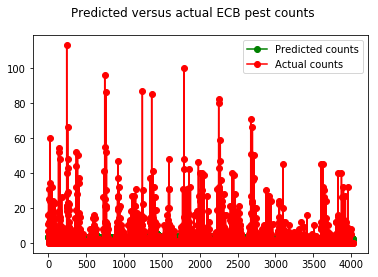

In [208]:
#Mlot the predicted counts versus the actual counts for the test data.
fig = plt.figure()
fig.suptitle('Predicted versus actual ECB pest counts ')
predicted, = plt.plot(X_test_ecb.index, predicted_counts_ecb, 'go-', label='Predicted counts')
actual, = plt.plot(X_test_ecb.index, actual_counts_ecb, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

In [210]:
df_ECB_final['predicted_counts_ecb'] = predicted_counts_ecb

In [211]:
#writing into the csv file
df_ECB_final.to_csv("ECB_predicted_count.csv", index = False, sep = ',')

# selecting weather dataframe within the date range - FAW Pest

In [224]:
print(search_faw_STdate)
print(search_faw_ENDdate)

2006-06-19 00:00:00
2018-10-15 00:00:00


In [225]:
df_equation_FAW = df_equation.loc[(df_equation['valid'] >= search_faw_STdate) & (df_equation['valid'] <= search_faw_ENDdate), :]

In [226]:
#need to get all the columns from here and sum up fro every week 
#select date and each column, and find the average for each column
df_tempf_FAW = df_equation_FAW[['tmpf','dwpf', 'drct','feel','valid']]
df_tempf_FAW["tmpf"] = df_tempf_FAW["tmpf"].fillna(0)
df_tempf_FAW["dwpf"] = df_tempf_FAW["dwpf"].fillna(0)
df_tempf_FAW["drct"] = df_tempf_FAW["drct"].fillna(0)
df_tempf_FAW["feel"] = df_tempf_FAW["feel"].fillna(0)

In [227]:
#calling getweekly_temperature
FAW_weather_data_dic = {}
getweekly_temperature(df_tempf_FAW,FAW_weather_data_dic)

total temperature index  642
total weeks:  47922


In [228]:
df_FAW_weather = pd.DataFrame(FAW_weather_data_dic)

In [229]:
#convert orginal faw date into correct dataframe date
df_FAW['date'] = df_FAW['date'].dt.date

In [230]:
#combining weather data and pest count data based on the date -----
#creating data frame needed for equation
df_FAW_weather['date'] = pd.to_datetime(df_FAW_weather['date'])
df_FAW_weather['date'] = df_FAW_weather['date'].dt.date
df_FAW_final = df_FAW.merge(df_FAW_weather, on='date')

In [232]:
df_FAW_final.head()

farm  trap_count  year        date      tempf       dwpf  \
0      Pelham-G           0  2006  2006-06-19  70.977613  63.913169   
1  Litchfield-W           0  2006  2006-06-19  70.977613  63.913169   
2  Litchfield-M           0  2006  2006-06-19  70.977613  63.913169   
3   Merrimack-T           0  2006  2006-06-19  70.977613  63.913169   
4      Hollis-L           0  2006  2006-06-19  70.977613  63.913169   

        drct       feel  
0  63.703704  71.301399  
1  63.703704  71.301399  
2  63.703704  71.301399  
3  63.703704  71.301399  
4  63.703704  71.301399

# predicting trap counts :::: FAW pest

In [233]:
#creating training and testign dataset 
mask_faw = np.random.rand(len(df_FAW_final)) < 0.8
df_train_FAW = df_FAW_final[mask_faw]
df_test_FAW = df_FAW_final[~mask_faw]

In [234]:
expr_FAW = """trap_count ~ tempf + dwpf + drct + feel"""

In [235]:
#Set up the X and y matrices
y_train_faw, X_train_faw = dmatrices(expr_FAW, df_FAW_final, return_type='dataframe')
y_test_faw, X_test_faw = dmatrices(expr_FAW, df_FAW_final, return_type='dataframe')

In [236]:
#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results_faw = sm.GLM(y_train_faw, X_train_faw, family=sm.families.Poisson()).fit()

In [237]:
print(poisson_training_results_faw.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                 2634
Model:                            GLM   Df Residuals:                     2629
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13336.
Date:                Mon, 06 Apr 2020   Deviance:                       23704.
Time:                        08:28:51   Pearson chi2:                 7.29e+04
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0710      0.084     12.699      0.000       0.906       1.236
tempf          0.0774      0.011      7.154      0.0

In [238]:
#Make some predictions on the test data set.
poisson_predictions_faw = poisson_training_results_faw.get_prediction(X_test_faw)

In [239]:
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame_faw = poisson_predictions_faw.summary_frame()
print(predictions_summary_frame_faw)

          mean   mean_se  mean_ci_lower  mean_ci_upper
0     1.901839  0.048888       1.808393       2.000113
1     1.901839  0.048888       1.808393       2.000113
2     1.901839  0.048888       1.808393       2.000113
3     1.901839  0.048888       1.808393       2.000113
4     1.901839  0.048888       1.808393       2.000113
5     1.901839  0.048888       1.808393       2.000113
6     1.901839  0.048888       1.808393       2.000113
7     1.901839  0.048888       1.808393       2.000113
8     1.901839  0.048888       1.808393       2.000113
9     1.901839  0.048888       1.808393       2.000113
10    1.901839  0.048888       1.808393       2.000113
11    1.681121  0.038086       1.608107       1.757450
12    1.681121  0.038086       1.608107       1.757450
13    1.681121  0.038086       1.608107       1.757450
14    1.681121  0.038086       1.608107       1.757450
15    1.681121  0.038086       1.608107       1.757450
16    1.681121  0.038086       1.608107       1.757450
17    1.68

In [240]:
predicted_counts_faw=predictions_summary_frame_faw['mean']
actual_counts_faw = y_test_faw['trap_count']

In [242]:
print(predicted_counts_faw)

0       1.901839
1       1.901839
2       1.901839
3       1.901839
4       1.901839
5       1.901839
6       1.901839
7       1.901839
8       1.901839
9       1.901839
10      1.901839
11      1.681121
12      1.681121
13      1.681121
14      1.681121
15      1.681121
16      1.681121
17      1.681121
18      1.681121
19      1.681121
20      1.681121
21      1.681121
22      3.362671
23      3.362671
24      3.362671
25      3.362671
26      3.362671
27      3.362671
28      3.362671
29      3.362671
          ...   
2604    2.568579
2605    2.568579
2606    2.566849
2607    2.566849
2608    2.566849
2609    2.566849
2610    2.566849
2611    2.566849
2612    2.566849
2613    2.566849
2614    2.566849
2615    2.566849
2616    2.566849
2617    2.566849
2618    2.566849
2619    2.566849
2620    2.566849
2621    2.566849
2622    2.566849
2623    2.566849
2624    2.479989
2625    2.479989
2626    2.479989
2627    2.479989
2628    2.479989
2629    2.479989
2630    2.479989
2631    2.4799

In [243]:
print(actual_counts_faw)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        0.0
8        0.0
9        0.0
10       0.0
11       0.0
12       0.0
13       0.0
14       0.0
15       0.0
16       0.0
17       0.0
18       0.0
19       0.0
20       0.0
21       0.0
22       0.0
23       0.0
24       0.0
25       0.0
26       0.0
27       0.0
28       0.0
29       0.0
        ... 
2604     1.0
2605     0.0
2606     5.0
2607    16.0
2608    32.0
2609     0.0
2610     2.0
2611     0.0
2612     0.0
2613     2.0
2614    22.0
2615    10.0
2616     0.0
2617     0.0
2618     0.0
2619     1.0
2620     2.0
2621     0.0
2622     1.0
2623     0.0
2624     0.0
2625     2.0
2626     0.0
2627     0.0
2628     0.0
2629     2.0
2630     0.0
2631     2.0
2632     0.0
2633     0.0
Name: trap_count, Length: 2634, dtype: float64


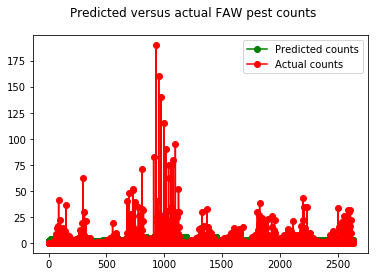

In [245]:
#Mlot the predicted counts versus the actual counts for the test data.
fig = plt.figure()
fig.suptitle('Predicted versus actual FAW pest counts ')
predicted, = plt.plot(X_test_faw.index, predicted_counts_faw, 'go-', label='Predicted counts')
actual, = plt.plot(X_test_faw.index, actual_counts_faw, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

In [246]:
df_FAW_final['predicted_counts_faw'] = predicted_counts_faw

In [247]:
#writing into the csv file
df_FAW_final.to_csv("FAW_predicted_count.csv", index = False, sep = ',')